In [1]:
import torch
from torch.nn import functional as F
from torch.utils.cpp_extension import load
import os

os.environ["TORCH_CUDA_ARCH_LIST"] = "8.6" # for our RTX 3090. Modify for your own GPU.
os.environ["MAX_JOBS"] = "16" # use some of Bentham's many cores
hash_attn_kernel = load(
    name="hash_attn", sources=[os.path.normpath(os.path.join(os.getcwd(), "../source/splashattn/splash_main.cpp")), 
                                  os.path.normpath(os.path.join(os.getcwd(), "../source/splashattn/splash.cu"))], 
                                  extra_cuda_cflags=["-O2"],
)

### QK sparsity

In the SCFA paper, QK sparsity is a proof of concept where we randomly drop some of the QK indices.

In [2]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
def reference_qk_sparse_attn(q, k, v, sm_scale: float = 1.0, indices_to_keep: torch.Tensor = None, keep_prob: float = 0.2):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    B, H, N, D = q.shape
    if indices_to_keep is None:
        indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
        indices_to_keep = torch.sort(indices_to_keep)[0]
    q_slice = q[..., indices_to_keep, :]
    k_slice = k[..., indices_to_keep, :]
    v_slice = v[..., indices_to_keep, :]
    n_slice = len(indices_to_keep)
    attn_scores = torch.matmul(q_slice, k_slice.transpose(-2, -1)) * sm_scale
    attn_mask = torch.ones(B, H, n_slice, n_slice, device = q.device, dtype = torch.bool)
    attn_mask = torch.tril(attn_mask, diagonal = 0)
    attn_scores = attn_scores.masked_fill(~attn_mask, float("-inf"))
    attn = F.softmax(attn_scores, dim=-1)
    # sns.heatmap(attn.cpu().numpy().squeeze(), annot = False, cmap = "viridis")
    # plt.show()
    # return
    attn = attn.nan_to_num(0.0) # some cols will be totally masked out and softmax will produce NaNs
    slice_out = torch.matmul(attn, v_slice)
    out = torch.zeros_like(q)
    out[..., indices_to_keep, :] = slice_out
    return out


q = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
k = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
reference_qk_sparse_attn(q, k, v)

tensor([[[[ 0.8011, -0.7273, -0.6196,  ..., -1.3203,  0.5557,  1.8944],
          [ 1.5036, -0.9085, -0.7826,  ..., -0.7876, -0.7594, -1.0429],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.5999,  0.7420,  0.5620,  ..., -0.4729,  0.1432,  0.3321],
          [ 0.1258, -0.0058, -0.2736,  ...,  0.1335,  0.2536,  1.0688]]]],
       device='cuda:0')

### Our QK Sparse kernel:

In [3]:
def kernel_qk_sparse_attn(q, k, v, sm_scale: float = 1.0, indices_to_keep: torch.Tensor = None, keep_prob: float = 0.2):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    B, H, N, D = q.shape
    if indices_to_keep is None:
        indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
        indices_to_keep = torch.sort(indices_to_keep)[0]
    out = torch.zeros_like(q)
    q = q[..., indices_to_keep, :]
    k = k[..., indices_to_keep, :]
    v = v[..., indices_to_keep, :]
    Q_idx = torch.arange(N, device=q.device).view(1, 1, N)
    Q_idx = Q_idx.expand(B, H, N)[..., indices_to_keep].contiguous().int()
    K_idx = torch.arange(N, device=q.device).view(1, 1, N)
    K_idx = K_idx.expand(B, H, N)[..., indices_to_keep].contiguous().int()
    kernel_output = hash_attn_kernel.forward(q, k, v, Q_idx, K_idx, sm_scale)
    # print(out[..., indices_to_keep, :].shape, kernel_output.shape)
    out[..., indices_to_keep, :] = kernel_output
    return out

q = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
k = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
kernel_qk_sparse_attn(q, k, v)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

### Correctness check:

Mean absolute error:  tensor(2.2876e-09, device='cuda:0')


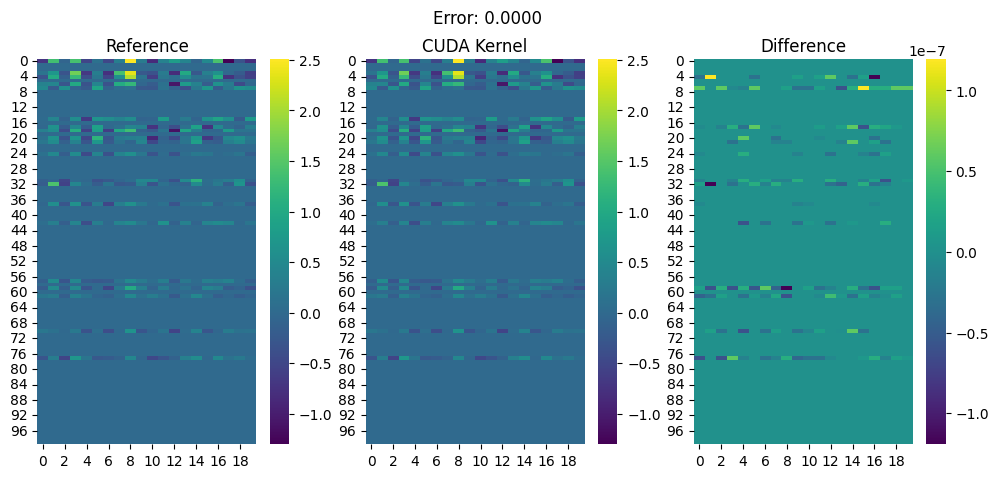

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
B = 1
H = 1
N = 100
D = 20
keep_prob = 0.2

q = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
k = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
v = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
indices_to_keep = torch.sort(indices_to_keep)[0]
reference_output = reference_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
kernel_output = kernel_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)

mae = (reference_output - kernel_output).abs().mean()
print("Mean absolute error: ", mae)
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
sns.heatmap(reference_output.squeeze().cpu().numpy(), annot = False, ax = axes[0], cmap = "viridis")
sns.heatmap(kernel_output.squeeze().cpu().numpy(), annot = False, ax = axes[1], cmap = "viridis")
sns.heatmap(kernel_output.squeeze().cpu().numpy() - reference_output.squeeze().cpu().numpy(), annot = False, ax = axes[2], cmap = "viridis")
axes[0].set_title("Reference")
axes[1].set_title("CUDA Kernel")
axes[2].set_title("Difference")
plt.suptitle(f"Error: {mae:.4f}")
plt.show()


### SCFA's Reference Implementation:

Mean absolute error:  tensor(7.6424e-05, device='cuda:0')


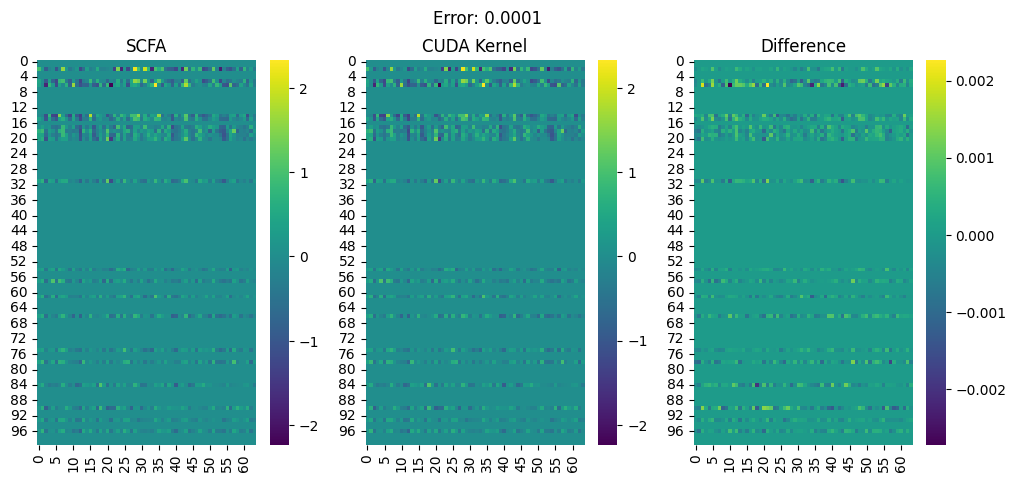

In [8]:
from source.scfa_paper.scfa_wrapper import qk_sparse_attention
import seaborn as sns
from matplotlib import pyplot as plt
B = 1
H = 1
N = 100
D = 64
keep_prob = 0.2

q = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
k = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
v = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
indices_to_keep = torch.sort(indices_to_keep)[0]
kernel_output = kernel_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)

def prep_scfa_input(q, k, v, indices_to_keep):
    # Prepare input for SCFA kernel
    B, H, N, D = q.shape
    binary_mask = torch.zeros(B, H, N, device = "cuda", dtype=torch.float32)
    binary_mask[:, :, indices_to_keep] = 1.0
    binary_mask = binary_mask.transpose(1, 2).contiguous() # (B, N, H) -> as SCFA expects
    scfa_q = q.clone().transpose(1, 2).contiguous() # (B, N, H, D) -> as SCFA expects
    scfa_k = k.clone().transpose(1, 2).contiguous()
    scfa_v = v.clone().transpose(1, 2).contiguous()

    return scfa_q, scfa_k, scfa_v, binary_mask

def prep_scfa_output(scfa_output):
    return scfa_output.transpose(1, 2)

scfa_q, scfa_k, scfa_v, binary_mask = prep_scfa_input(q, k, v, indices_to_keep)
scfa_output = qk_sparse_attention(scfa_q, scfa_k, scfa_v, 
                                q_keep = binary_mask.clone(), 
                                k_keep = binary_mask.clone(), 
                                sm_scale = 1.0 / math.sqrt(D))
scfa_output = prep_scfa_output(scfa_output)

mae = (kernel_output - scfa_output).abs().mean()
print("Mean absolute error: ", mae)
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
sns.heatmap(scfa_output.squeeze().cpu().numpy(), annot = False, ax = axes[0], cmap = "viridis")
sns.heatmap(kernel_output.squeeze().cpu().numpy(), annot = False, ax = axes[1], cmap = "viridis")
sns.heatmap(scfa_output.squeeze().cpu().numpy() - kernel_output.squeeze().cpu().numpy(), annot = False, ax = axes[2], cmap = "viridis")
axes[0].set_title("SCFA")
axes[1].set_title("CUDA Kernel")
axes[2].set_title("Difference")
plt.suptitle(f"Error: {mae:.4f}")
plt.show()


### Sanity Check (this should pass):

In [9]:
B = 1
H = 1
N = 100
D = 64
keep_prob = 0.2

q = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
k = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
v = torch.randn(B, H, N, D, device = "cuda", dtype=torch.float32)
indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
indices_to_keep = torch.sort(indices_to_keep)[0]
kernel_output = kernel_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
reference_output = reference_qk_sparse_attn(q.clone(), k.clone(), v.clone(), sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
scfa_q, scfa_k, scfa_v, binary_mask = prep_scfa_input(q, k, v, indices_to_keep)
scfa_output = qk_sparse_attention(scfa_q, scfa_k, scfa_v, 
                                q_keep = binary_mask.clone(), 
                                k_keep = binary_mask.clone(), 
                                sm_scale = 1.0 / math.sqrt(D))
scfa_output = prep_scfa_output(scfa_output)

print("Paper <> Reference Max Error: ", (scfa_output - reference_output).abs().max())
print("Reference <> CUDA Max Error: ", (reference_output - kernel_output).abs().max())
print("Paper <> CUDA Max Error: ", (kernel_output - scfa_output).abs().max())

assert (kernel_output - scfa_output).abs().max() < 5e-3, "SCFA and CUDA kernel outputs should match"
assert (kernel_output - reference_output).abs().max() < 5e-3, "CUDA kernel and reference outputs should match"
assert (scfa_output - reference_output).abs().max() < 5e-3, "SCFA and reference outputs should match"

Paper <> Reference Max Error:  tensor(0.0026, device='cuda:0')
Reference <> CUDA Max Error:  tensor(3.5763e-07, device='cuda:0')
Paper <> CUDA Max Error:  tensor(0.0026, device='cuda:0')


In [10]:
scfa_q.shape, scfa_k.shape, scfa_v.shape, binary_mask.shape

(torch.Size([1, 100, 1, 64]),
 torch.Size([1, 100, 1, 64]),
 torch.Size([1, 100, 1, 64]),
 torch.Size([1, 100, 1]))

### Speed Comparison:

Benchmarking sequence length: 256
  Standard: 0.0001s
  Reference QK: 0.0002s
  Kernel QK: 0.0003s
  SCFA QK: 0.0006s
Benchmarking sequence length: 512
  Standard: 0.0001s
  Reference QK: 0.0003s
  Kernel QK: 0.0004s
  SCFA QK: 0.0006s
Benchmarking sequence length: 1024
  Standard: 0.0003s
  Reference QK: 0.0003s
  Kernel QK: 0.0006s
  SCFA QK: 0.0006s
Benchmarking sequence length: 2048
  Standard: 0.0008s
  Reference QK: 0.0003s
  Kernel QK: 0.0011s
  SCFA QK: 0.0006s
Benchmarking sequence length: 4096
  Standard: 0.0026s
  Reference QK: 0.0006s
  Kernel QK: 0.0023s
  SCFA QK: 0.0008s
Benchmarking sequence length: 8192
  Standard: 0.0091s
  Reference QK: 0.0023s
  Kernel QK: 0.0064s
  SCFA QK: 0.0011s
Benchmarking sequence length: 16384
  Standard: 0.0353s
  Reference QK: 0.0071s
  Kernel QK: 0.0197s
  SCFA QK: 0.0021s
Benchmarking sequence length: 32768
  Standard: 0.1465s
  Reference QK: 0.0299s
  Kernel QK: 0.0725s
  SCFA QK: 0.0051s


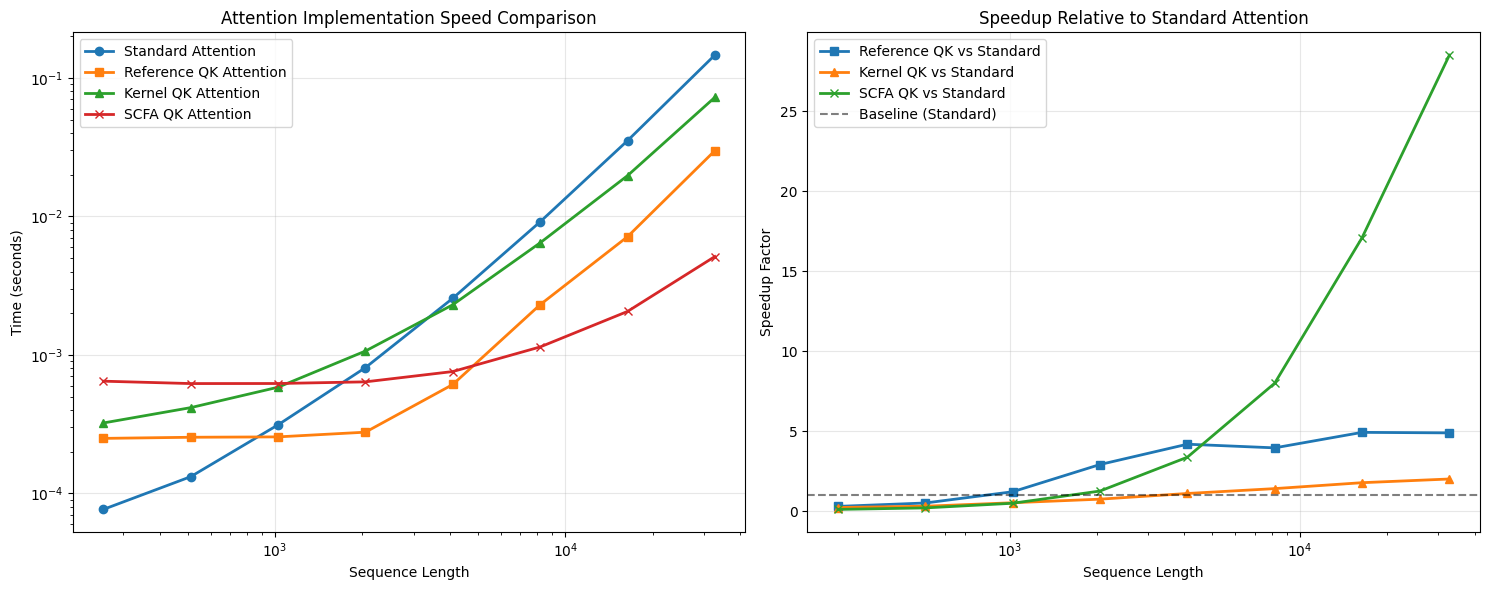


Benchmark Summary:
Seq Len    Standard (s)    Reference (s)   Kernel (s)      Ref Speedup  Kernel Speedup  SCFA (s)        SCFA Speedup   
--------------------------------------------------------------------------------
256        0.0001          0.0002          0.0003          0.31        x 0.24           x 0.0006          0.12           x
512        0.0001          0.0003          0.0004          0.52        x 0.32           x 0.0006          0.21           x
1024       0.0003          0.0003          0.0006          1.22        x 0.53           x 0.0006          0.50           x
2048       0.0008          0.0003          0.0011          2.93        x 0.76           x 0.0006          1.27           x
4096       0.0026          0.0006          0.0023          4.20        x 1.11           x 0.0008          3.38           x
8192       0.0091          0.0023          0.0064          3.97        x 1.42           x 0.0011          8.01           x
16384      0.0353          0.0071        

In [ ]:
import time
import torch.nn.functional as F

# Benchmark code courtesy of Claude 4.0
def benchmark_attention_methods(seq_lens, d_model=64, num_heads=8, num_buckets=16, num_trials=10):
    """Benchmark different attention implementations across various sequence lengths."""
    results = {
        'seq_lens': [],
        'standard_attention': [],
        'reference_qk_attention': [],
        'kernel_qk_attention': [],
        'scfa_qk_attention': []
    }
    
    for seq_len in seq_lens:
        print(f"Benchmarking sequence length: {seq_len}")
        
        # Generate test data
        B, H, N, D = 1, num_heads, seq_len, d_model
        q = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        k = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        v = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        
        indices_to_keep = torch.randperm(N, device="cuda")[:math.floor(N * keep_prob)].int()
        indices_to_keep = torch.sort(indices_to_keep)[0]
        
        # Warm up GPU
        for _ in range(3):
            _ = F.scaled_dot_product_attention(q, k, v, is_causal=True)
            _ = reference_qk_sparse_attn(q, k, v, sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
            _ = kernel_qk_sparse_attn(q, k, v, sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
        
        torch.cuda.synchronize()
        
        # Benchmark standard attention
        times_standard = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = F.scaled_dot_product_attention(q, k, v, is_causal=True)
            torch.cuda.synchronize()
            times_standard.append(time.time() - start_time)
        
        # Benchmark reference qk attention
        times_reference = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = reference_qk_sparse_attn(q, k, v, sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
            torch.cuda.synchronize()
            times_reference.append(time.time() - start_time)
        
        # Benchmark kernel qk attention
        times_kernel = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = kernel_qk_sparse_attn(q, k, v, sm_scale = 1.0 / math.sqrt(D), indices_to_keep = indices_to_keep)
            torch.cuda.synchronize()
            times_kernel.append(time.time() - start_time)

        # Benchmark SCFA Triton qk attention
        times_scfa = []
        for _ in range(num_trials):
            scfa_q, scfa_k, scfa_v, binary_mask = prep_scfa_input(q, k, v, indices_to_keep)
            start_time = time.time()
            _ = qk_sparse_attention(scfa_q, scfa_k, scfa_v, 
                                q_keep = binary_mask.clone(), 
                                k_keep = binary_mask.clone(), 
                                sm_scale = 1.0 / math.sqrt(D))
            torch.cuda.synchronize()
            times_scfa.append(time.time() - start_time)
        
        # Store results (average times)
        results['seq_lens'].append(seq_len)
        results['standard_attention'].append(sum(times_standard) / len(times_standard))
        results['reference_qk_attention'].append(sum(times_reference) / len(times_reference))
        results['kernel_qk_attention'].append(sum(times_kernel) / len(times_kernel))
        results['scfa_qk_attention'].append(sum(times_scfa) / len(times_scfa))

        print(f"  Standard: {results['standard_attention'][-1]:.4f}s")
        print(f"  Reference QK: {results['reference_qk_attention'][-1]:.4f}s")
        print(f"  Kernel QK: {results['kernel_qk_attention'][-1]:.4f}s")
        print(f"  SCFA QK: {results['scfa_qk_attention'][-1]:.4f}s")
    return results

# Run benchmark
seq_lengths = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
benchmark_results = benchmark_attention_methods(seq_lengths)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Absolute times
ax1.plot(benchmark_results['seq_lens'], benchmark_results['standard_attention'], 'o-', label='Standard Attention', linewidth=2)
ax1.plot(benchmark_results['seq_lens'], benchmark_results['reference_qk_attention'], 's-', label='Reference QK Attention', linewidth=2)
ax1.plot(benchmark_results['seq_lens'], benchmark_results['kernel_qk_attention'], '^-', label='Kernel QK Attention', linewidth=2)
ax1.plot(benchmark_results['seq_lens'], benchmark_results['scfa_qk_attention'], 'x-', label='SCFA QK Attention', linewidth=2)
ax1.set_xlabel('Sequence Length')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Attention Implementation Speed Comparison')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup relative to standard attention
standard_times = benchmark_results['standard_attention']
reference_speedup = [std/ref for std, ref in zip(standard_times, benchmark_results['reference_qk_attention'])]
kernel_speedup = [std/ker for std, ker in zip(standard_times, benchmark_results['kernel_qk_attention'])]
scfa_speedup = [std/scfa for std, scfa in zip(standard_times, benchmark_results['scfa_qk_attention'])]

ax2.plot(benchmark_results['seq_lens'], reference_speedup, 's-', label='Reference QK vs Standard', linewidth=2)
ax2.plot(benchmark_results['seq_lens'], kernel_speedup, '^-', label='Kernel QK vs Standard', linewidth=2)
ax2.plot(benchmark_results['seq_lens'], scfa_speedup, 'x-', label='SCFA QK vs Standard', linewidth=2)
ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Baseline (Standard)')
ax2.set_xlabel('Sequence Length')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup Relative to Standard Attention')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table
print("\nBenchmark Summary:")
print("=" * 80)
print(f"{'Seq Len':<10} {'Standard (s)':<15} {'Reference (s)':<15} {'Kernel (s)':<15} {'Ref Speedup':<12} {'Kernel Speedup':<15} {'SCFA (s)':<15} {'SCFA Speedup':<15}")
print("-" * 80)
for i, seq_len in enumerate(benchmark_results['seq_lens']):
    std_time = benchmark_results['standard_attention'][i]
    ref_time = benchmark_results['reference_qk_attention'][i]
    ker_time = benchmark_results['kernel_qk_attention'][i]
    scfa_time = benchmark_results['scfa_qk_attention'][i]
    ref_speedup = std_time / ref_time
    ker_speedup = std_time / ker_time
    scfa_speedup = std_time / scfa_time
    print(f"{seq_len:<10} {std_time:<15.4f} {ref_time:<15.4f} {ker_time:<15.4f} {ref_speedup:<12.2f}x {ker_speedup:<15.2f}x {scfa_time:<15.4f} {scfa_speedup:<15.2f}x")


## Locality-Sensitive Hashing
See mechanism described in the Reformer paper: https://arxiv.org/pdf/2001.04451

We hash $Q$ and $K$ into $B$ buckets by using a random matrix $R \in \mathbb{R}^{d \times b/2}$ and taking $\argmax([xR; −xR])$. As per the Johnson-Lindenstrauss lemma, this maps $Q$ and $K$ into a $b/2$-dimensional space in a relative-distance preserving way.

In [44]:
def vector_hash_fn(x: torch.Tensor, num_buckets: int, R: torch.Tensor) -> torch.Tensor:
    """
    x: (..., D)
    R: (D, b/2)
    """
    D = x.shape[-1]
    assert R.shape == (D, num_buckets // 2)
    return torch.argmax(torch.cat([x @ R, -x @ R], dim=-1), dim=-1)

def get_vector_hash(D: int, num_buckets: int, device: torch.device = "cpu") -> torch.Tensor:
    R = torch.randn(D, num_buckets // 2, device = device)
    return lambda x: vector_hash_fn(x, num_buckets, R)

vector_hash = get_vector_hash(D = 10, num_buckets = 10)
vector_hash(torch.randn(50, 10))

tensor([0, 2, 9, 4, 4, 9, 6, 4, 5, 2, 4, 9, 1, 0, 3, 9, 7, 0, 7, 5, 7, 4, 9, 6,
        5, 6, 4, 0, 9, 2, 9, 5, 9, 2, 9, 4, 5, 4, 7, 4, 6, 4, 4, 0, 7, 9, 4, 6,
        4, 6])

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
def reference_hash_attn(q, k, v, num_buckets: int, sm_scale: float = 1.0, vector_hash = None):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)

    Note: This implementation sucks! It's just a sanity check.
    """
    assert num_buckets % 2 == 0, "num_buckets must be even"
    if vector_hash is None:
        vector_hash = get_vector_hash(D = q.shape[-1], num_buckets = num_buckets, device = q.device)
    B, H, N, D = q.shape
    q_hashes = vector_hash(q) # (B, H, N)
    k_hashes = vector_hash(k) # (B, H, N)
    out = torch.zeros_like(q)
    for i in range(num_buckets):
        for b in range(B):
            for h in range(H):
                q_mask = (q_hashes[b][h] == i) # (N)
                k_mask = (k_hashes[b][h] == i) # (N)
                q_indices = torch.nonzero(q_mask, as_tuple=False).squeeze() # (N)
                k_indices = torch.nonzero(k_mask, as_tuple=False).squeeze() # (N)
                if q_indices.numel() == 0 or k_indices.numel() == 0:
                    continue
                q_bucket = q[b, h, q_indices] # (N, D)
                k_bucket = k[b, h, k_indices] # (N, D)
                v_bucket = v[b, h, k_indices] # (N, D)
                attn_mask = q_indices.unsqueeze(-1) >= k_indices.unsqueeze(-2)
                attn_scores = torch.matmul(q_bucket, k_bucket.transpose(-2, -1)) * sm_scale
                attn_scores = attn_scores.masked_fill(~attn_mask, float("-inf"))
                attn = F.softmax(attn_scores, dim=-1)
                attn = attn.nan_to_num(0.0) # some cols will be totally masked out and softmax will produce NaNs
                # sns.heatmap(attn.cpu().numpy().squeeze(), annot = False, mask = ~attn_mask.cpu().numpy().squeeze())
                # plt.show()
                # return
                partial_prod = torch.matmul(attn, v_bucket)
                out[b, h, q_indices] += partial_prod
    return out

q = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
k = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
reference_hash_attn(q, k, v, num_buckets=4)

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0555,  2.1686, -0.1285,  ..., -0.1854,  1.4034, -0.1349],
          ...,
          [ 0.4240, -0.8775,  0.2057,  ...,  0.0227, -0.4229, -0.1248],
          [ 0.5334,  0.3552, -0.4873,  ..., -0.2971,  0.3565, -0.3472],
          [ 0.4409, -0.7329,  0.2249,  ...,  0.2465,  0.6863, -0.4976]]]],
       device='cuda:0')

## Comparison with our CUDA kernel:

In [4]:
import math
B = 16  # batch_size    H = 12  # num heads
H = 12  # num heads
N = 64  # seq_len
D = 48  # head_dim (adjusted to be divisible by H)
sm_scale = 1.0 / math.sqrt(D)

q = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
k = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
v = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)

Q_idx = torch.arange(N, device=q.device).view(1, 1, N)
Q_idx = Q_idx.expand(B, H, N).contiguous().int()

K_idx = torch.arange(N, device=q.device).view(1, 1, N)
K_idx = K_idx.expand(B, H, N).contiguous().int()

print("=== Profiling splash attention ===")
with torch.autograd.profiler.profile(use_device="cuda") as prof:
    minimal_out = hash_attn_kernel.forward(q, k, v, Q_idx, K_idx, sm_scale)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

=== Profiling splash attention ===
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
         aten::zeros_like         0.41%      11.981us         2.45%      71.935us      71.935us      18.000us        13.74%      76.000us      76.000us             1  
              aten::zero_         0.39%      11.512us         1.41%      41.358us      20.679us      19.000us        14.50%      47.000us      23.500us             2  
              aten::fill_         0.48%      14.036us         0.95%      27.842us       9.281us      37.000us        28.24% 

In [5]:
def kernel_hash_attn(q, k, v, num_buckets: int, sm_scale: float = 1.0, vector_hash = None):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    assert num_buckets % 2 == 0, "num_buckets must be even"
    if vector_hash is None:
        vector_hash = get_vector_hash(D = q.shape[-1], num_buckets = num_buckets, device = q.device)
    B, H, N, D = q.shape
    q_hashes = vector_hash(q) # (B, H, N)
    k_hashes = vector_hash(k) # (B, H, N)
    Q_idx = torch.arange(N, device=q.device).view(1, 1, N)
    Q_idx = Q_idx.expand(B, H, N).contiguous().int()
    K_idx = torch.arange(N, device=q.device).view(1, 1, N)
    K_idx = K_idx.expand(B, H, N).contiguous().int()
    max_q_size, max_k_size = 0, 0
    out = torch.zeros_like(q)
    for i in range(num_buckets):
        for b in range(B):
            for h in range(H):
                num_q = (q_hashes[b][h] == i).sum() # (N)
                num_k = (k_hashes[b][h] == i).sum() # (N)
                max_q_size = max(max_q_size, num_q)
                max_k_size = max(max_k_size, num_k)
        q_tensor = torch.zeros(B, H, max_q_size, D, device = q.device, dtype=torch.float32)
        k_tensor = torch.zeros(B, H, max_k_size, D, device = q.device, dtype=torch.float32)
        v_tensor = torch.zeros(B, H, max_k_size, D, device = q.device, dtype=torch.float32)
        q_idx_tensor = torch.zeros(B, H, max_q_size, device = q.device, dtype=torch.int32)
        k_idx_tensor = torch.zeros(B, H, max_k_size, device = q.device, dtype=torch.int32)
        pad_mask_q = torch.zeros(B, H, max_q_size, device = q.device, dtype=torch.bool)
        for b in range(B):
            for h in range(H):
                q_mask = (q_hashes[b][h] == i)
                k_mask = (k_hashes[b][h] == i)
                num_q = q_mask.sum()
                num_k = k_mask.sum()
                q_tensor[b, h, :num_q] = q[b, h, q_mask]
                k_tensor[b, h, :num_k] = k[b, h, k_mask]
                v_tensor[b, h, :num_k] = v[b, h, k_mask]
                q_idx_tensor[b, h, :num_q] = Q_idx[b, h, q_mask]
                k_idx_tensor[b, h, :num_k] = K_idx[b, h, k_mask]
                pad_mask_q[b, h, :num_q] = True

        # Note that, at this point, q_idx_tensor and k_idx_tensor should already be sorted due to their initialization with arange
        q_tensor, q_idx_tensor, k_tensor, k_idx_tensor = q_tensor.contiguous(), q_idx_tensor.contiguous(), k_tensor.contiguous(), k_idx_tensor.contiguous()
        kernel_out = hash_attn_kernel.forward(q_tensor, k_tensor, v_tensor, q_idx_tensor, k_idx_tensor, sm_scale)
        kernel_out = kernel_out.masked_fill(~pad_mask_q.unsqueeze(-1), 0.0)
        # print(kernel_out.shape, max_q_size, max_k_size, q_idx_tensor.shape, k_idx_tensor.shape, q_tensor.shape, k_tensor.shape)
        # print(q_idx_tensor)
        batch_idx = torch.arange(B).view(B, 1, 1).expand(B, H, max_q_size)
        head_idx = torch.arange(H).view(1, H, 1).expand(B, H, max_q_size)
        out[batch_idx, head_idx, q_idx_tensor] += kernel_out
    return out

q = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
k = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, 20, device = "cuda", dtype=torch.float32)
kernel_hash_attn(q, k, v, num_buckets=4)

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.2665,  0.0507, -1.0651,  ...,  0.9246,  1.0098, -0.5036],
          [-0.8341,  1.5032, -1.5586,  ...,  2.1525, -2.1555,  0.7183],
          ...,
          [ 0.1509,  0.0840, -0.2537,  ...,  0.3475,  0.2093,  0.2483],
          [ 0.6254,  0.6377,  0.5675,  ...,  0.2496, -0.0661, -1.3288],
          [-0.2426, -0.3476, -0.0389,  ...,  1.2819,  0.0843,  0.5678]]]],
       device='cuda:0')

### Correctness check:

Mean absolute error:  tensor(0.0117, device='cuda:0')


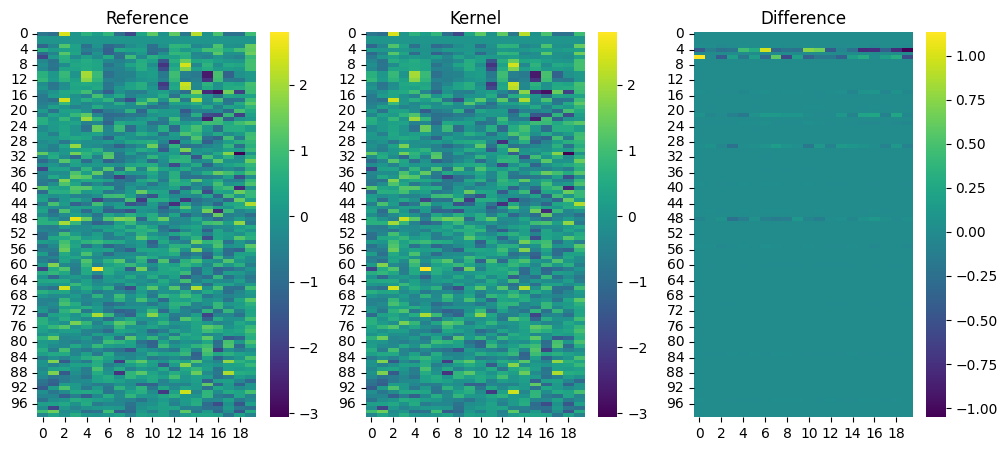

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt
D = 20
q = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.float32)
k = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.float32)
v = torch.randn(1, 1, 100, D, device = "cuda", dtype=torch.float32)
standard_vector_hash = get_vector_hash(D = D, num_buckets = 4, device = "cuda")
reference_output =reference_hash_attn(q, k, v, num_buckets = 4, vector_hash = standard_vector_hash)
kernel_output = kernel_hash_attn(q, k, v, num_buckets = 4, vector_hash = standard_vector_hash)

print("Mean absolute error: ", (reference_output - kernel_output).abs().mean())
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
sns.heatmap(reference_output.squeeze().cpu().numpy(), annot = False, ax = axes[0], cmap = "viridis")
sns.heatmap(kernel_output.squeeze().cpu().numpy(), annot = False, ax = axes[1], cmap = "viridis")
sns.heatmap(kernel_output.squeeze().cpu().numpy() - reference_output.squeeze().cpu().numpy(), annot = False, ax = axes[2], cmap = "viridis")
axes[0].set_title("Reference")
axes[1].set_title("Kernel")
axes[2].set_title("Difference")
plt.show()


## Speed comparison:

Benchmarking sequence length: 256
  Standard: 0.0001s
  Reference Hash: 0.0379s
  Kernel Hash: 0.0799s
Benchmarking sequence length: 512
  Standard: 0.0002s
  Reference Hash: 0.0382s
  Kernel Hash: 0.0820s
Benchmarking sequence length: 1024
  Standard: 0.0004s
  Reference Hash: 0.0385s
  Kernel Hash: 0.0848s
Benchmarking sequence length: 2048
  Standard: 0.0012s
  Reference Hash: 0.0387s
  Kernel Hash: 0.0915s
Benchmarking sequence length: 4096
  Standard: 0.0041s
  Reference Hash: 0.0391s
  Kernel Hash: 0.0999s
Benchmarking sequence length: 8192
  Standard: 0.0134s
  Reference Hash: 0.0429s
  Kernel Hash: 0.1774s
Benchmarking sequence length: 16384
  Standard: 0.0601s
  Reference Hash: 0.0424s
  Kernel Hash: 0.3808s
Benchmarking sequence length: 32768
  Standard: 0.2583s
  Reference Hash: 0.0860s
  Kernel Hash: 1.0033s


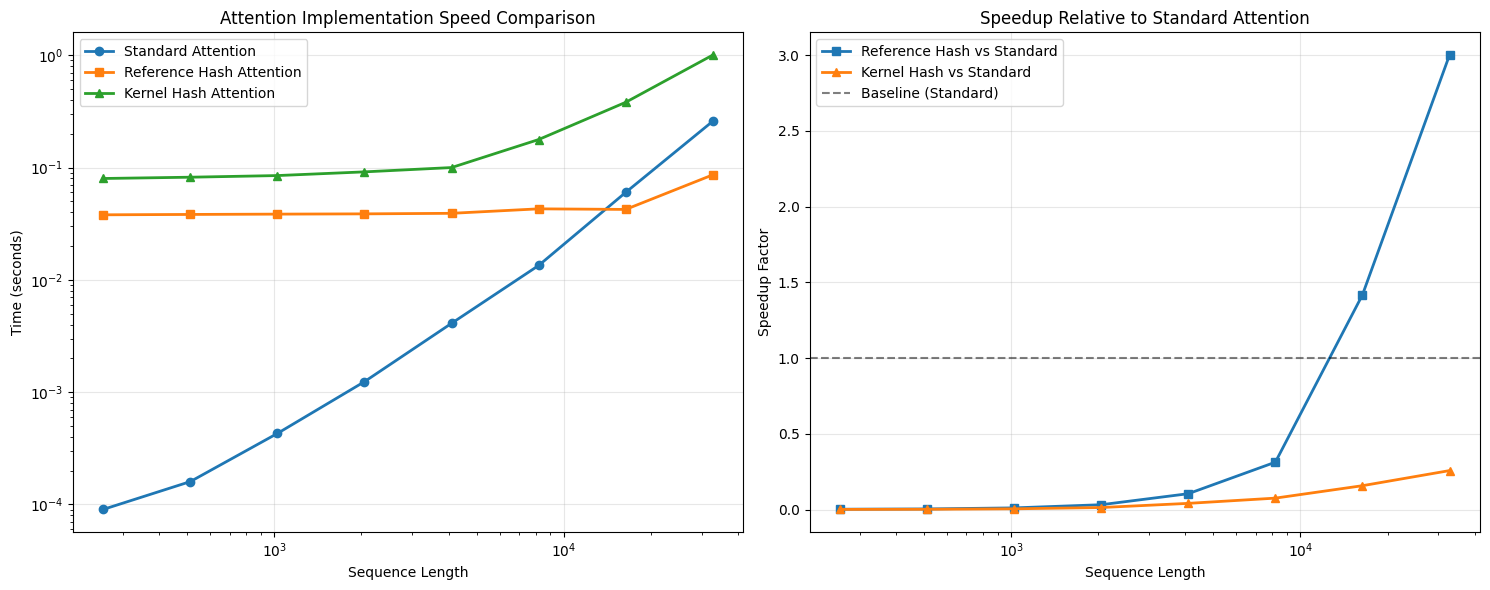


Benchmark Summary:
Seq Len    Standard (s)    Reference (s)   Kernel (s)      Ref Speedup  Kernel Speedup 
--------------------------------------------------------------------------------
256        0.0001          0.0379          0.0799          0.00        x 0.00           x
512        0.0002          0.0382          0.0820          0.00        x 0.00           x
1024       0.0004          0.0385          0.0848          0.01        x 0.01           x
2048       0.0012          0.0387          0.0915          0.03        x 0.01           x
4096       0.0041          0.0391          0.0999          0.10        x 0.04           x
8192       0.0134          0.0429          0.1774          0.31        x 0.08           x
16384      0.0601          0.0424          0.3808          1.42        x 0.16           x
32768      0.2583          0.0860          1.0033          3.00        x 0.26           x


In [7]:
import time
import torch.nn.functional as F

# Benchmark code courtesy of Claude 4.0
def benchmark_attention_methods(seq_lens, d_model=128, num_heads=8, num_buckets=16, num_trials=10):
    """Benchmark different attention implementations across various sequence lengths."""
    results = {
        'seq_lens': [],
        'standard_attention': [],
        'reference_hash_attention': [],
        'kernel_hash_attention': []
    }
    
    for seq_len in seq_lens:
        print(f"Benchmarking sequence length: {seq_len}")
        
        # Generate test data
        B, H, N, D = 1, num_heads, seq_len, d_model
        q = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        k = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        v = torch.randn(B, H, N, D, device="cuda", dtype=torch.float32)
        
        # Create shared vector hash for fair comparison
        standard_vector_hash = get_vector_hash(D=D, num_buckets=num_buckets, device="cuda")
        
        # Warm up GPU
        for _ in range(3):
            _ = F.scaled_dot_product_attention(q, k, v, is_causal=True)
            _ = reference_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
            _ = kernel_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
        
        torch.cuda.synchronize()
        
        # Benchmark standard attention
        times_standard = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = F.scaled_dot_product_attention(q, k, v, is_causal=True)
            torch.cuda.synchronize()
            times_standard.append(time.time() - start_time)
        
        # Benchmark reference hash attention
        times_reference = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = reference_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
            torch.cuda.synchronize()
            times_reference.append(time.time() - start_time)
        
        # Benchmark kernel hash attention
        times_kernel = []
        for _ in range(num_trials):
            start_time = time.time()
            _ = kernel_hash_attn(q, k, v, num_buckets=num_buckets, vector_hash=standard_vector_hash)
            torch.cuda.synchronize()
            times_kernel.append(time.time() - start_time)
        
        # Store results (average times)
        results['seq_lens'].append(seq_len)
        results['standard_attention'].append(sum(times_standard) / len(times_standard))
        results['reference_hash_attention'].append(sum(times_reference) / len(times_reference))
        results['kernel_hash_attention'].append(sum(times_kernel) / len(times_kernel))
        
        print(f"  Standard: {results['standard_attention'][-1]:.4f}s")
        print(f"  Reference Hash: {results['reference_hash_attention'][-1]:.4f}s")
        print(f"  Kernel Hash: {results['kernel_hash_attention'][-1]:.4f}s")
    
    return results

# Run benchmark
seq_lengths = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
benchmark_results = benchmark_attention_methods(seq_lengths)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Absolute times
ax1.plot(benchmark_results['seq_lens'], benchmark_results['standard_attention'], 'o-', label='Standard Attention', linewidth=2)
ax1.plot(benchmark_results['seq_lens'], benchmark_results['reference_hash_attention'], 's-', label='Reference Hash Attention', linewidth=2)
ax1.plot(benchmark_results['seq_lens'], benchmark_results['kernel_hash_attention'], '^-', label='Kernel Hash Attention', linewidth=2)
ax1.set_xlabel('Sequence Length')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Attention Implementation Speed Comparison')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup relative to standard attention
standard_times = benchmark_results['standard_attention']
reference_speedup = [std/ref for std, ref in zip(standard_times, benchmark_results['reference_hash_attention'])]
kernel_speedup = [std/ker for std, ker in zip(standard_times, benchmark_results['kernel_hash_attention'])]

ax2.plot(benchmark_results['seq_lens'], reference_speedup, 's-', label='Reference Hash vs Standard', linewidth=2)
ax2.plot(benchmark_results['seq_lens'], kernel_speedup, '^-', label='Kernel Hash vs Standard', linewidth=2)
ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Baseline (Standard)')
ax2.set_xlabel('Sequence Length')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup Relative to Standard Attention')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table
print("\nBenchmark Summary:")
print("=" * 80)
print(f"{'Seq Len':<10} {'Standard (s)':<15} {'Reference (s)':<15} {'Kernel (s)':<15} {'Ref Speedup':<12} {'Kernel Speedup':<15}")
print("-" * 80)
for i, seq_len in enumerate(benchmark_results['seq_lens']):
    std_time = benchmark_results['standard_attention'][i]
    ref_time = benchmark_results['reference_hash_attention'][i]
    ker_time = benchmark_results['kernel_hash_attention'][i]
    ref_speedup = std_time / ref_time
    ker_speedup = std_time / ker_time
    print(f"{seq_len:<10} {std_time:<15.4f} {ref_time:<15.4f} {ker_time:<15.4f} {ref_speedup:<12.2f}x {ker_speedup:<15.2f}x")
